In [8]:
import sys
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import os
import matplotlib.pyplot as plt
import numpy as np
import ot
import time
import numba as nb

from celluloid import Camera
from IPython.display import HTML
os.chdir(os.getcwd())
from sopt.library import *
from sopt.lib_shape import *
from sopt.lib_ot import *   
from sopt.sliced_opt import *   

/home/baly/projects/sliced_opt/sopt/sliced_opt.py:132: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 2d, A))
  X_theta=np.dot(theta,X.T)
/home/baly/projects/sliced_opt/sopt/sliced_opt.py:162: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, A), array(float32, 2d, A))
  X_theta=np.dot(theta,X.T)
/home/baly/projects/sliced_opt/sopt/lib_shape.py:456: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  beta=vec_mean(T)-vec_mean(scalar*S.dot(rotation))
/home/baly/projects/sliced_opt/sopt/lib_shape.py:472: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 2d, F))
  T_hat_theta=np.dot(theta,T_hat.T)
/home/baly/projects/sliced_opt/sopt/lib_shape.py:505: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 

In [9]:
def get_noise(Y0,Y1):
    N=Y1.shape[0]
    data_indices=[]
    noise_indices=[]
    for j in range(N):
        yj=Y1[j]
        if yj in Y0:
            data_indices.append(j)
        else:
            noise_indices.append(j)
    return np.array(data_indices),np.array(noise_indices)

    
    

def normal_image(T_data,S_data,T_noise=[],S_noise=[],name=None):
    
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    T_data-=T_data.mean(0)
    ax.scatter(T_data[:,0],T_data[:,1],T_data[:,2],alpha=.5,c='C2',s=5,marker='o')
    ax.scatter(S_data[:,0],S_data[:,1],S_data[:,2],alpha=.9,c='C1',s=5,marker='o')
    if len(T_noise)>0: 
        ax.scatter(T_noise[:,0],T_noise[:,1],T_noise[:,2],alpha=.5,c='C2',s=10,marker='o')
    if len(S_noise)>0:
        ax.scatter(S_noise[:,0],S_noise[:,1],S_noise[:,2],alpha=.5,c='C1',s=10,marker='o')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.axis('off')
    ax.set_facecolor('black') 
    ax.grid(True)
    
    ax.set_xlim([-0.08,0.08])
    ax.set_ylim([-.08,.08])
    ax.set_zlim([-.08,.08])

    ax.view_init(90, -90)
    # fig.set_facecolor('black')
    if name!=None:
        plt.savefig(name+'.pdf',dpi=200,format='pdf',bbox_inches='tight')
    plt.show()
    plt.close()
    
    # castle,   
    #x+3, z-15 
    # ax.set_xlim([-5,40])
    # ax.set_ylim([-5,40])
    # ax.set_zlim([-5,40])
    # ax.view_init(45,120)
#    ax.view_init(0,10,'y')


    # #mumble_sitting, bunny  
    # y-10
    # ax.set_xlim([-36,36])
    # ax.set_ylim([-36,36])
    # ax.set_zlim([-36,36])
    # ax.view_init(-20,10,'y')
    #ax.view_init( 90, -90)
     
    #dragon, bunny 
    #dragon y-0.1
    #bunny, x+0.02, y-0.1    


In [11]:
# generate noise: 
item='dragon'

item_list=['dragon']
n_point_list=['10k','9k']
noise_p_list=['5p','7p']
noise_pv_list=[0.05,0.7]
time_list={}

data_path='experiment/reviewer/data'

for item in item_list:
    data=torch.load('experiment/reviewer/data/'+item+'.pt')
    for noise_p,noise_pv in zip(noise_p_list,noise_pv_list):
        T0=data['T']
        n_T0=T0.shape[0]
        nT_noise=int(n_T0*noise_pv)
        noise_T=np.random.uniform(low=[-0.15,-0.15,-0.15],high=[0.15,0.15,0.15],size=(nT_noise,3)).astype(np.float32)
        T1=np.concatenate((T0,noise_T))
        data['T-'+noise_p]=T1
        for n_point in n_point_list:
            S0=data['S-'+n_point]
            n_S0=S0.shape[0]
            nS_noise=int(n_T0*noise_pv)
            noise_S=np.random.uniform(low=[-0.15,-0.15,-0.15],high=[0.15,0.15,0.15],size=(nS_noise,3)).astype(np.float32)
            S1=np.concatenate((S0,noise_S))
            data['S-'+n_point+'-'+noise_p]=S1
    torch.save(data,'experiment/reviewer/data/'+item+'_s.pt')




In [12]:

#plot the data 

n_point='10k'
noise_p='5p'
T0=data['T']
S0=data['S-'+n_point+'-'+noise_p]
T1=data['T-'+noise_p]
S1=data['S-'+n_point+'-'+noise_p]
N_S0=S0.shape[0]
N_T0=T0.shape[0]

#load the running time list
try:
    time_list32=torch.load('experiment/reviewer/result/time_list_shape.pt')
except:
    time_list32={}
    torch.save(time_list,'experiment/reviewer/result/time_list_shape.pt')
print('range of source point cloud is [%0.3f,%0.3f]'%(S0.min(),S0.max()))
print('range of source point cloud is [%0.3f,%0.3f]'%(T0.min(),T0.max()))

#time_list={}
#torch.save(time_list,'experiment/reviewer/result/time_list_shape.pt')

range of source point cloud is [-0.150,0.150]
range of source point cloud is [-0.108,0.197]


In [13]:
#our method
#load the data 

time_list32=torch.load('experiment/reviewer/result/time_list_shape.pt')
(n_point,noise_p)=('10k','5p')
T0=data['T']
S0=data['S-'+n_point]
T1=data['T-'+noise_p]
S1=data['S-'+n_point+'-'+noise_p]
print('sopt')

T=T1.copy()
S=S1.copy()
N0=S0.shape[0]
start_time=time.time()
n_iterations=5
rotation_list,scalar_list,beta_list =sopt_main_32(S,T,n_iterations,N0)
end_time=time.time()
wall_time=end_time-start_time
result={}
result['wall_time']=wall_time
result['n_iterations']=n_iterations
result['time_per_iteration']=wall_time/n_iterations

time_list32['sopt'+'-'+item+'-'+n_point+'-'+noise_p]=result
print('time per iteration',wall_time/n_iterations)
print('end')
torch.save(time_list32,'experiment/reviewer/result/time_list_shape.pt')
paramlist=save_parameter(rotation_list,scalar_list,beta_list,'experiment/reviewer/result/'+item+'/'+n_point+'-'+noise_p+'/sopt_param.pt')

sopt
time per iteration 1.019420289993286
end


method sopt


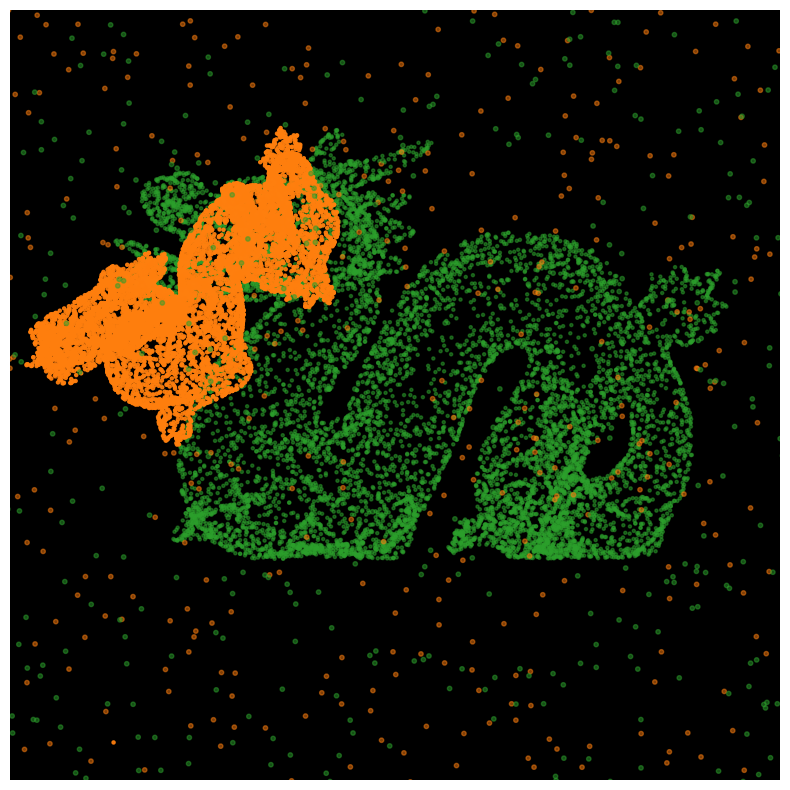

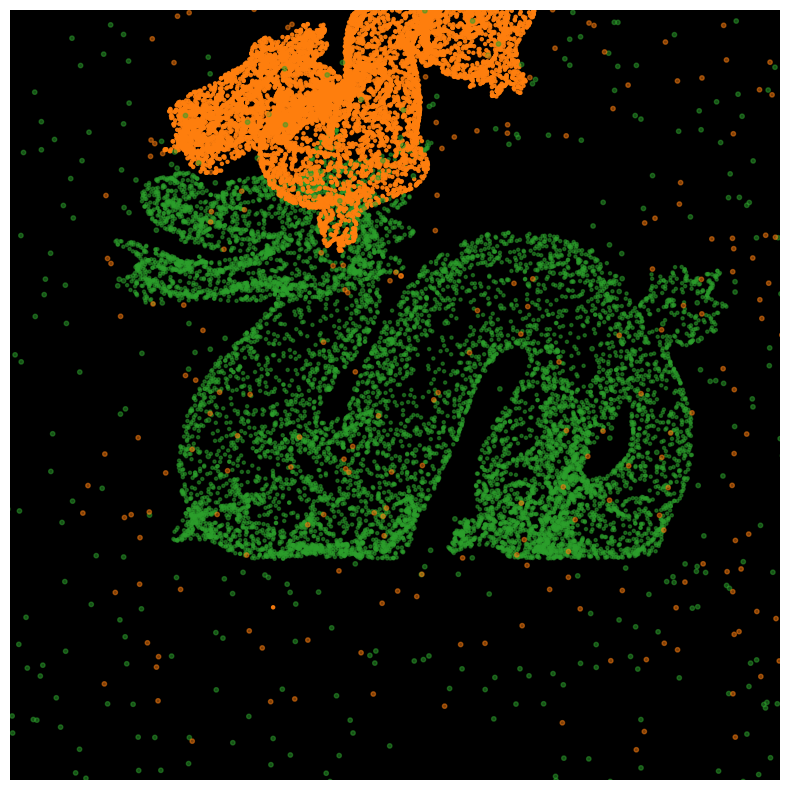

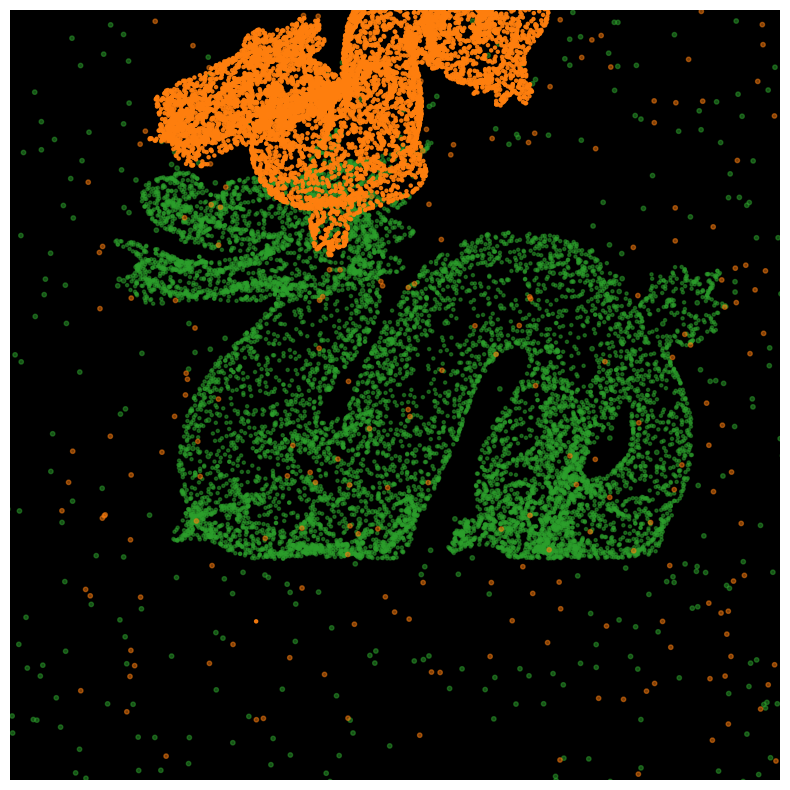

In [14]:
#visualization 
method='sopt'
print('method',method)

T0=data['T']
S0=data['S-'+n_point]
T1=data['T-'+noise_p]
S1=data['S-'+n_point+'-'+noise_p]

T=T1.copy()
S=S1.copy()
n=T1.shape[0]
data_indices_T=range(0,10000)
noise_indices_T=range(10000,n)
data_indices_S,noise_indices_S=get_noise(S0,S1)

T_data=T1[data_indices_T]
T_noise=T1[noise_indices_T]

S_data=S1[data_indices_S]
S_noise=S1[noise_indices_S]

name='experiment/reviewer/result/'+item+'/'+n_point+'-'+noise_p+'/init.pdf'
normal_image(T_data=T_data,S_data=S_data,T_noise=T_noise,S_noise=S_noise,name=name)

# load parameter: 
time_per_iteration=time_list32[method+'-'+item+'-'+n_point+'-'+noise_p]['time_per_iteration']
paramlist=torch.load('experiment/reviewer/result/'+item+'/'+n_point+'-'+noise_p+'/'+method+'_param.pt')
N=len(paramlist)
k_list=[]
for k in range(5):
    index=k*60/time_per_iteration
    if index<N:
        k_list.append(int(k*60/time_per_iteration))
k_list.append(N-1)

for k in k_list:
    param=paramlist[k]
    rotation=param['rotation']
    beta=param['beta']
    scalar=param['scalar']
    T_hat=S1@rotation*scalar+beta
    T_hat_data=T_hat[data_indices_S]
    T_hat_noise=T_hat[noise_indices_S]
    name='experiment/reviewer/result/'+item+'/'+n_point+'-'+noise_p+'/'+method+'/'+str(k)
    normal_image(T_data,T_hat_data,T_noise,T_hat_noise,name=name)

In [20]:
# SPOT Boneel 
#load the data 
time_dict={}
method='spot'
T0=data['T'] #.to(torch.float32)
S0=data['S-'+n_point] #.to(torch.float32)
T1=data['T-'+noise_p] #.to(torch.float32)
S1=data['S-'+n_point+'-'+noise_p] #.to(torch.float32)
print('spot')

T=T1.copy()
S=S1.copy()
N0=S0.shape[0]
n_projections=5 #20
n_iterations=2 #100
start_time=time.time()
rotation_list,scalar_list,beta_list =spot_bonneel_32(S,T,n_projections,n_iterations)
end_time=time.time()
wall_time=end_time-start_time
result={}
result['wall_time']=wall_time
result['n_iterations']=n_iterations
result['per_time']=wall_time/n_iterations

time_list32['spot'][item+n_point+noise_p]=result
print('noise_p',wall_time/n_iterations)
print('end')
torch.save(time_list32,'experiment/shape_registration/result/time_list32.pt')
save_parameter(rotation_list,scalar_list,beta_list,save_path+method+'_param.pt')

spot


KeyError: 'spot'

In [ ]:
#visualize the result 
time_list32=torch.load('experiment/shape_registration/result/time_list32.pt')
method='/spot'
image_path='experiment/shape_registration/result'+item+'/'+n_point+noise_p+method

print('noise_p',noise_p)
print('method',method)
T0=data['T0'].to(torch.float32)
S0=data['S0-'+n_point].to(torch.float32)
T1=data['T1'+noise_p].to(torch.float32)
S1=data['S1-'+n_point+noise_p].to(torch.float32)
T=T1.numpy().copy()
S=S1.numpy().copy()
n=T1.shape[0]
data_indices_T=range(0,10000)
noise_indices_T=range(10000,n)
data_indices_S,noise_indices_S=get_noise(S0,S1)

T_data=T1[data_indices_T]
T_noise=T1[noise_indices_T]

S_data=S1[data_indices_S]
S_noise=S1[noise_indices_S]

init_image(T_data,T_noise,S_data,S_noise,image_path,'init0')

# need to modify the parameters in function normal_image to have a better plot  
normal_image(T_data,T_noise,S_data,S_noise,image_path,'init')

# load parameter: 
per_time=time_list32[method[1:]][item+n_point+noise_p]['per_time']
paramlist=torch.load(save_path+method+'_param.pt')
N=len(paramlist)
k_list=[]
for k in range(1,5):
    index=k*60/per_time
    if index<N:
        k_list.append(int(k*60/per_time))
k_list.append(N-1)

for k in k_list:
    param=paramlist[k]
    rotation=param['rotation']
    beta=param['beta']
    scalar=param['scalar']
    T_hat=S1@rotation*scalar+beta
    T_hat_data=T_hat[data_indices_S]
    T_hat_noise=T_hat[noise_indices_S]
    fig = plt.figure(figsize=(5,5))
    camera = Camera(fig)
    normal_image(T_data,T_noise,T_hat_data,T_hat_noise,image_path,str(k))

In [ ]:
# icp-du
#load the data 
method='/icp-du'
time_dict={}

T0=data['T0'].to(torch.float32)
S0=data['S0-'+n_point].to(torch.float32)
T1=data['T1'+noise_p].to(torch.float32)
S1=data['S1-'+n_point+noise_p].to(torch.float32)
print('icp-du')

T=T1.numpy().copy()
S=S1.numpy().copy()
N0=S0.shape[0]
#n_projections=20
n_iterations=20
start_time=time.time()
rotation_list,scalar_list,beta_list =icp_du_32(S,T,n_iterations)
end_time=time.time()
wall_time=end_time-start_time
result={}
result['wall_time']=wall_time
result['n_iterations']=n_iterations
result['per_time']=wall_time/n_iterations

time_list32['icp-du'][item+n_point+noise_p]=result
print('noise_p',wall_time/n_iterations)
print('end')
torch.save(time_list32,'experiment/shape_registration/result/time_list32.pt')
save_parameter(rotation_list,scalar_list,beta_list,save_path+method+'_param.pt')


experiment/shape_registration/result/witchcastle/10k-5p/icp-du
per_s -5p
method /icp-du


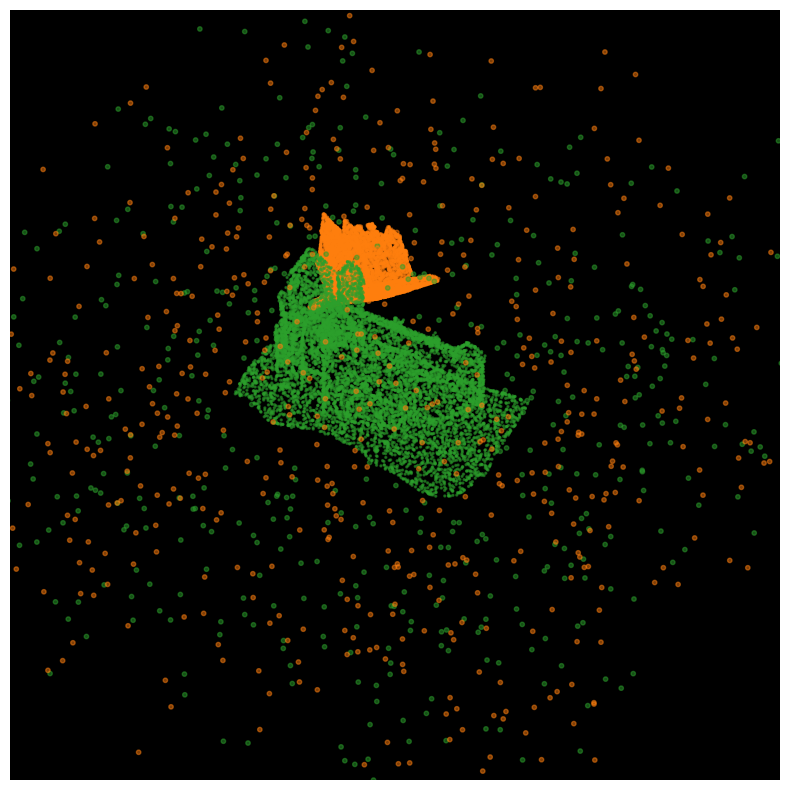

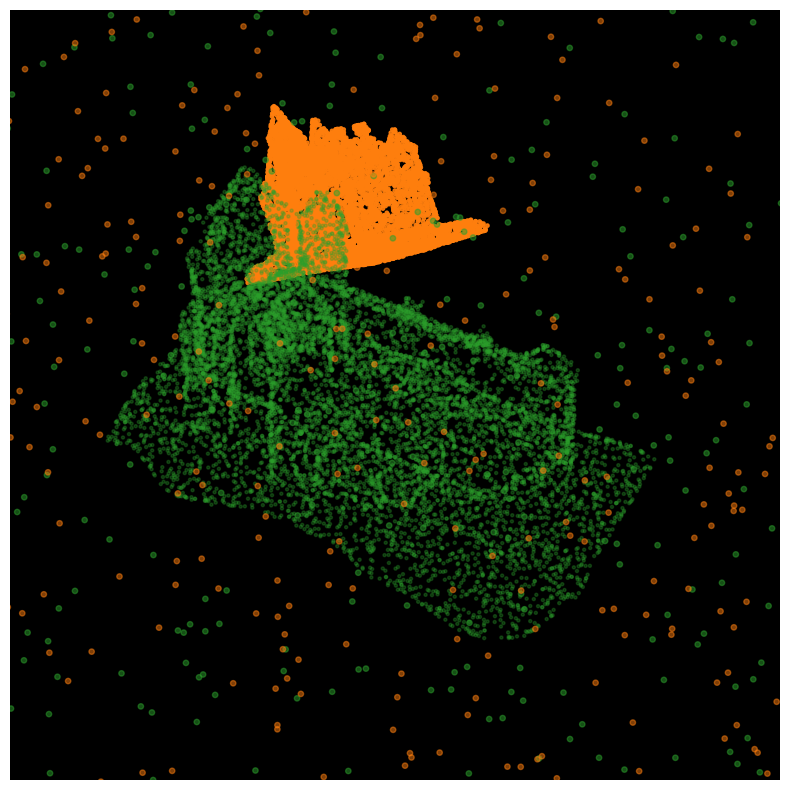

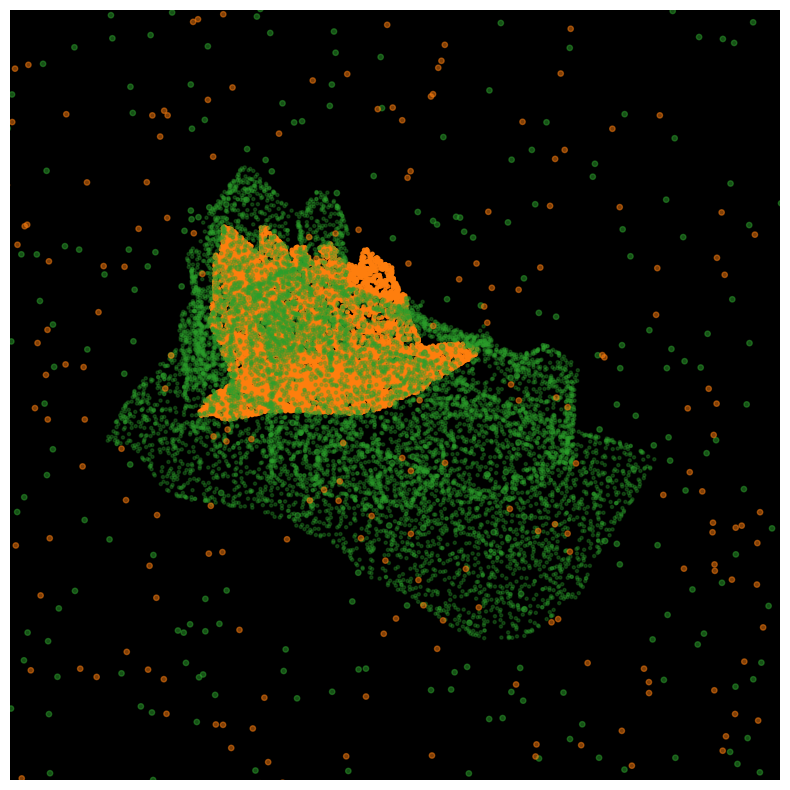

In [17]:
#visualize the result 
method='/icp-du'
time_list32=torch.load('experiment/shape_registration/result/time_list32.pt')

image_path='experiment/shape_registration/result'+item+'/'+n_point+noise_p+method
print(image_path)
print('noise_p',noise_p)
print('method',method)
T0=data['T0'].to(torch.float32)
S0=data['S0-'+n_point].to(torch.float32)
T1=data['T1'+noise_p].to(torch.float32)
S1=data['S1-'+n_point+noise_p].to(torch.float32)
T=T1.numpy().copy()
S=S1.numpy().copy()
n=T1.shape[0]
data_indices_T=range(0,10000)
noise_indices_T=range(10000,n)
data_indices_S,noise_indices_S=get_noise(S0,S1)

T_data=T1[data_indices_T]
T_noise=T1[noise_indices_T]

S_data=S1[data_indices_S]
S_noise=S1[noise_indices_S]

init_image(T_data,T_noise,S_data,S_noise,image_path,'init0')

# need to modify the parameters in function normal_image to have a better plot  
normal_image(T_data,T_noise,S_data,S_noise,image_path,'init')

# load parameter: 
per_time=time_list32[method[1:]][item+n_point+noise_p]['per_time']
paramlist=torch.load(save_path+method+'_param.pt')
N=len(paramlist)
k_list=[]
for k in range(1,5):
    index=k*60/per_time
    if index<N:
        k_list.append(int(k*60/per_time))
k_list.append(N-1)

for k in k_list:
    param=paramlist[k]
    rotation=param['rotation']
    beta=param['beta']
    scalar=param['scalar']
    T_hat=S1@rotation*scalar+beta
    T_hat_data=T_hat[data_indices_S]
    T_hat_noise=T_hat[noise_indices_S]
    normal_image(T_data,T_noise,T_hat_data,T_hat_noise,image_path,str(k))

In [ ]:
#animation
#animation
fig = plt.figure(figsize=(10,10))
camera = Camera(fig)
ax = fig.add_subplot(projection='3d')
for k in range(0,N):
#    time.sleep(per_time)
    param=paramlist[k]
    rotation=param['rotation']
    beta=param['beta']
    scalar=param['scalar']
    T_hat=S1@rotation*scalar+beta
    T_hat_data=T_hat[data_indices_S]
    T_hat_noise=T_hat[noise_indices_S]   
    ax.scatter(T_data[:,0]+3,T_data[:,1],T_data[:,2]-15,alpha=.3,c='C2',s=5,marker='o')
    ax.scatter(T_noise[:,0]+3,T_noise[:,1],T_noise[:,2]-15,alpha=.5,c='C2',s=15,marker='o')
    ax.scatter(T_hat_data[:,0]+3,T_hat_data[:,1],T_hat_data[:,2]-15,alpha=.9,c='C1',s=6,marker='o')
    ax.scatter(T_hat_noise[:,0]+3,T_hat_noise[:,1],T_hat_noise[:,2]-15,alpha=.5,c='C1',s=15,marker='o')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.axis('off')
    ax.set_facecolor('black') 
    ax.grid(True)

    # castle,   
    #x+3, z-15 
    ax.set_xlim([-20,20])
    ax.set_ylim([-20,20])
    ax.set_zlim([-20,20])
    ax.view_init(45,120)
    camera.snap()
animation = camera.animate(interval=1000)
HTML(animation.to_html5_video())

In [18]:
# icp-umeyama
#load the data 
method='/icp-umeyama'
time_dict={}

T0=data['T0'].to(torch.float32)
S0=data['S0-'+n_point].to(torch.float32)
T1=data['T1'+noise_p].to(torch.float32)
S1=data['S1-'+n_point+noise_p].to(torch.float32)
print('icp-umeyama')

T=T1.numpy().copy()
S=S1.numpy().copy()
N0=S0.shape[0]
#n_projections=20
n_iterations=300
start_time=time.time()
rotation_list,scalar_list,beta_list =icp_du_32(S,T,n_iterations)
end_time=time.time()
wall_time=end_time-start_time
result={}
result['wall_time']=wall_time
result['n_iterations']=n_iterations
result['per_time']=wall_time/n_iterations

time_list32[method[1:]][item+n_point+noise_p]=result
print('noise_p',wall_time/n_iterations)
print('end')
torch.save(time_list32,'experiment/shape_registration/result/time_list32.pt')
save_parameter(rotation_list,scalar_list,beta_list,save_path+method+'_param.pt')


icp-umeyama
per_s 0.05903845071792602
end


experiment/shape_registration/result/witchcastle/10k-5p/icp-umeyama
per_s -5p
method /icp-umeyama


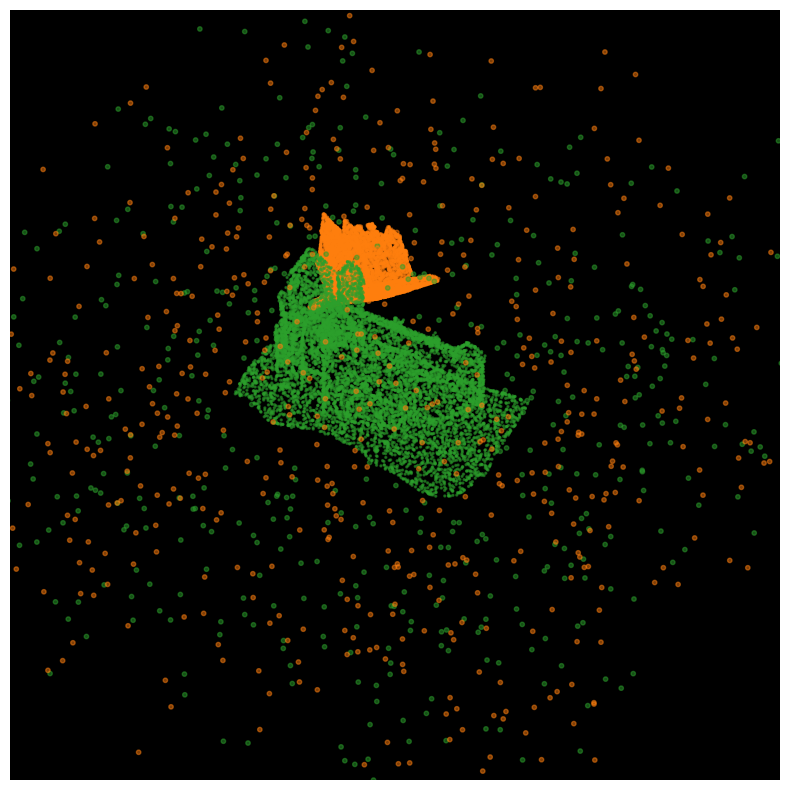

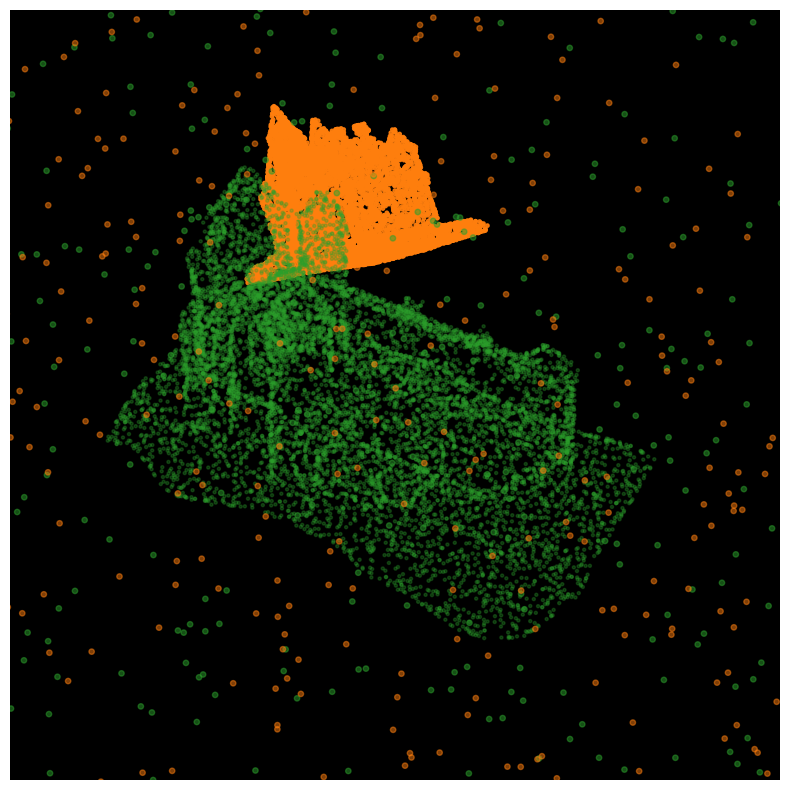

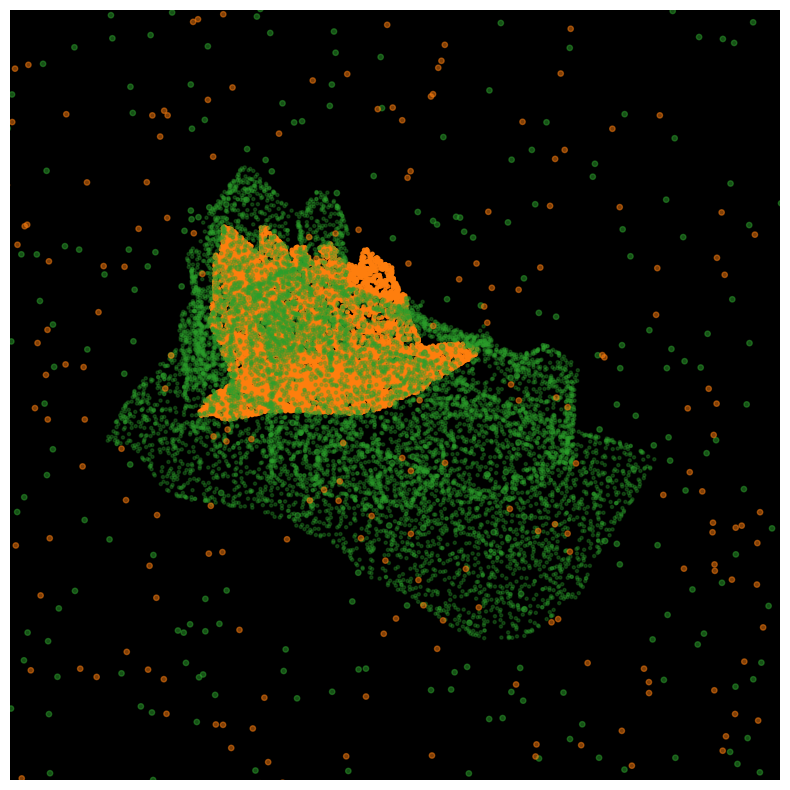

In [19]:
#visualize the result 
method='/icp-umeyama'
time_list32=torch.load('experiment/shape_registration/result/time_list32.pt')

image_path='experiment/shape_registration/result'+item+'/'+n_point+noise_p+method
print(image_path)
print('noise_p',noise_p)
print('method',method)
T0=data['T0'].to(torch.float32)
S0=data['S0-'+n_point].to(torch.float32)
T1=data['T1'+noise_p].to(torch.float32)
S1=data['S1-'+n_point+noise_p].to(torch.float32)
T=T1.numpy().copy()
S=S1.numpy().copy()
n=T1.shape[0]
data_indices_T=range(0,10000)
noise_indices_T=range(10000,n)
data_indices_S,noise_indices_S=get_noise(S0,S1)

T_data=T1[data_indices_T]
T_noise=T1[noise_indices_T]

S_data=S1[data_indices_S]
S_noise=S1[noise_indices_S]

init_image(T_data,T_noise,S_data,S_noise,image_path,'init0')

# need to modify the parameters in function normal_image to have a better plot  
normal_image(T_data,T_noise,S_data,S_noise,image_path,'init')

# load parameter: 
per_time=time_list32[method[1:]][item+n_point+noise_p]['per_time']
paramlist=torch.load(save_path+method+'_param.pt')
N=len(paramlist)
k_list=[]
for k in range(1,5):
    index=k*60/per_time
    if index<N:
        k_list.append(int(k*60/per_time))
k_list.append(N-1)

for k in k_list:
    param=paramlist[k]
    rotation=param['rotation']
    beta=param['beta']
    scalar=param['scalar']
    T_hat=S1@rotation*scalar+beta
    T_hat_data=T_hat[data_indices_S]
    T_hat_noise=T_hat[noise_indices_S]
    normal_image(T_data,T_noise,T_hat_data,T_hat_noise,image_path,str(k))

In [ ]:
#animation
#animation
fig = plt.figure(figsize=(10,10))
camera = Camera(fig)
ax = fig.add_subplot(projection='3d')
for k in range(0,N):
#    time.sleep(per_time)
    param=paramlist[k]
    rotation=param['rotation']
    beta=param['beta']
    scalar=param['scalar']
    T_hat=S1@rotation*scalar+beta
    T_hat_data=T_hat[data_indices_S]
    T_hat_noise=T_hat[noise_indices_S]   
    ax.scatter(T_data[:,0]+3,T_data[:,1],T_data[:,2]-15,alpha=.3,c='C2',s=5,marker='o')
    ax.scatter(T_noise[:,0]+3,T_noise[:,1],T_noise[:,2]-15,alpha=.5,c='C2',s=15,marker='o')
    ax.scatter(T_hat_data[:,0]+3,T_hat_data[:,1],T_hat_data[:,2]-15,alpha=.9,c='C1',s=6,marker='o')
    ax.scatter(T_hat_noise[:,0]+3,T_hat_noise[:,1],T_hat_noise[:,2]-15,alpha=.5,c='C1',s=15,marker='o')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.axis('off')
    ax.set_facecolor('black') 
    ax.grid(True)

    # castle,   
    #x+3, z-15 
    ax.set_xlim([-20,20])
    ax.set_ylim([-20,20])
    ax.set_zlim([-20,20])
    ax.view_init(45,120)
    camera.snap()
animation = camera.animate(interval=1000)
HTML(animation.to_html5_video())